<a href="https://colab.research.google.com/github/sthepaut/SAFRAN_ENSAI_2025/blob/ENSAI_students/performancemodel_ENSAI/notebook/Ensai_notebook2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025
!git clone -b ENSAI_students https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025

Cloning into 'SAFRAN_ENSAI_2025'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 53), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (144/144), 2.47 MiB | 9.48 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
# Verify that we have sucessfully clone the repo and go the place where the repo is stored
%cd /content/SAFRAN_ENSAI_2025
!ls

/content/SAFRAN_ENSAI_2025
Cie_0_Engine0.csv	performancemodel_ENSAI.zip
performancemodel_ENSAI	README.md


In [3]:
# install the package performance_model
%cd /content/SAFRAN_ENSAI_2025/performancemodel_ENSAI/
!pip install .

/content/SAFRAN_ENSAI_2025/performancemodel_ENSAI
Processing /content/SAFRAN_ENSAI_2025/performancemodel_ENSAI
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for performancemodel: filename=performancemodel-0.0.1-py3-none-any.whl size=30485 sha256=85a76051553975ffe8c9390f3b6279ee808ff849f409b16e05ff8948fe22467b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nuu8cx6c/wheels/b4/6e/66/25433221b4a4d2ead6faf834b0fa81054260e4a8996e629ab9
Successfully built performancemodel


In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

from performancemodel.base_system import h_SCSF
from performancemodel.scenarios import simulate_degradation_trajectory, generate_multiple_trajectories
from performancemodel.plot import plot_trajectory



**What was done:**  
Added the **third component** from the simulator by updating the files:
- `simulate_degradation_trajectory`
- `h_SCSF`
- `plot.py`

This allows the simulator to handle both 2 and 3 degradation components (compressor, turbine, and combustion).

---


# Challenge SCSF

In this notebok we show how to create data for a challenge with the simulator SCSF implemented in this library and propose a solution to the challenge. This notebook will be divided into three parts :

1) Data Generation
2) Solver Construction
3) Tests and Results

## Data Generation

In this chapter we show how to construct degradation trajectories and how to get measurements from the simulator along the trajectories.

### Trajectory generation

The SCSF simulator has only two degrading modules, the compressor and the turbine. For each of this module, we have an health indicator that can vary between 1.95 and 1.02. We will now show how to construct degradation trajectories for each of this indicator.

In [2]:
traj = simulate_degradation_trajectory()
traj_waterwash =simulate_degradation_trajectory(waterwash="frequent")
traj_fast = simulate_degradation_trajectory(speed="fast")

Plot with 2 components : comp, turb

In [41]:
# Convert the list of trajectories into arrays 
traj_arr = np.asarray(traj , dtype=float)

n_steps, n_comp = traj_arr .shape
comp = traj_arr[:, 0] # get compressor component
turb = traj_arr[:, 1]  # get turbine component
comb = traj_arr[:, 2] if n_comp > 2 else np.ones(n_steps)   # get combustion component if any


traj_arr = np.asarray(traj , dtype=float)
traj_waterwash_arr = np.asarray(traj_waterwash  , dtype=float)
traj_fast_arr = np.asarray(traj_fast , dtype=float)

In [38]:
traj_arr.shape

(100, 3)

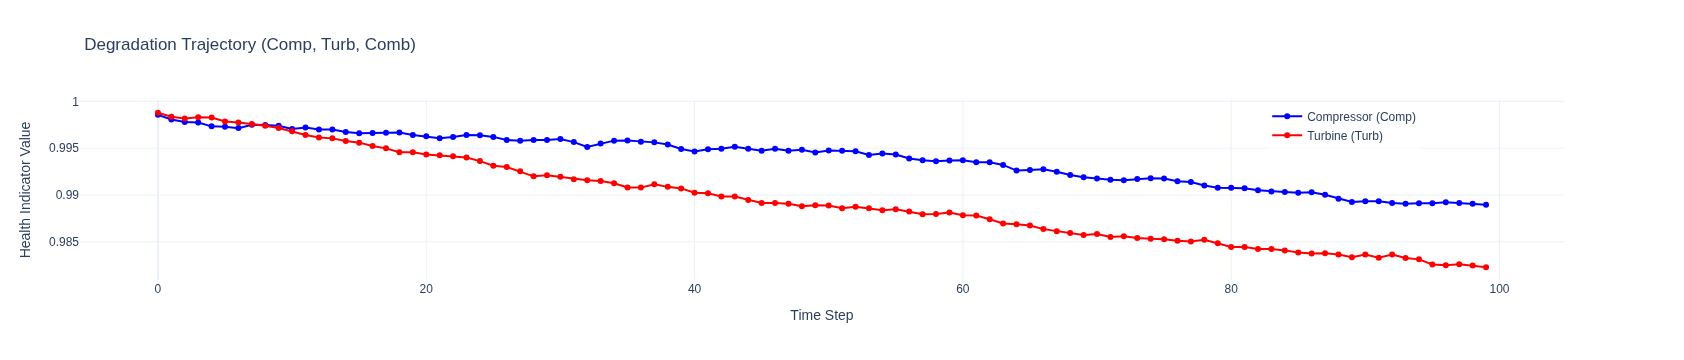

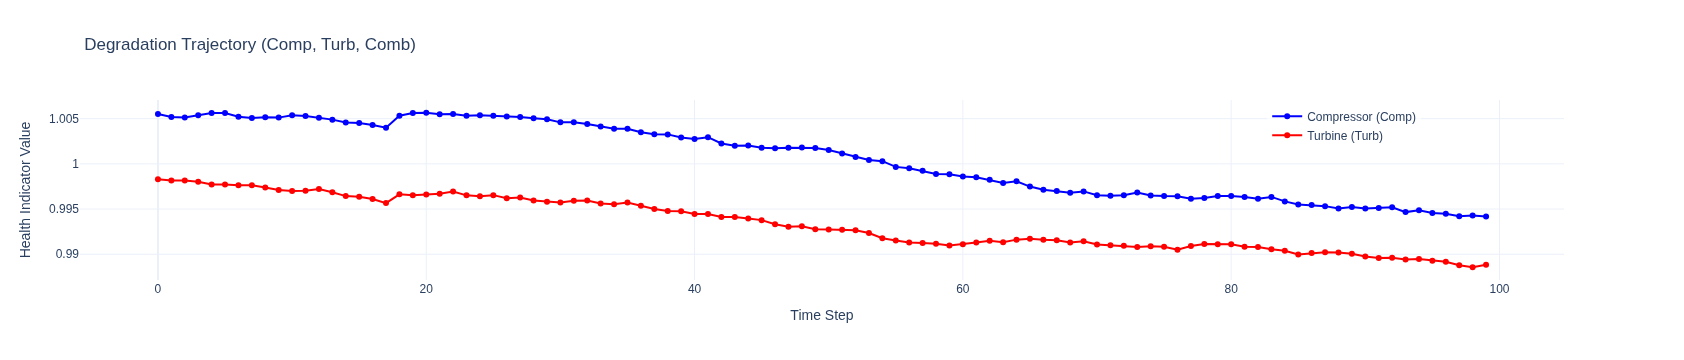

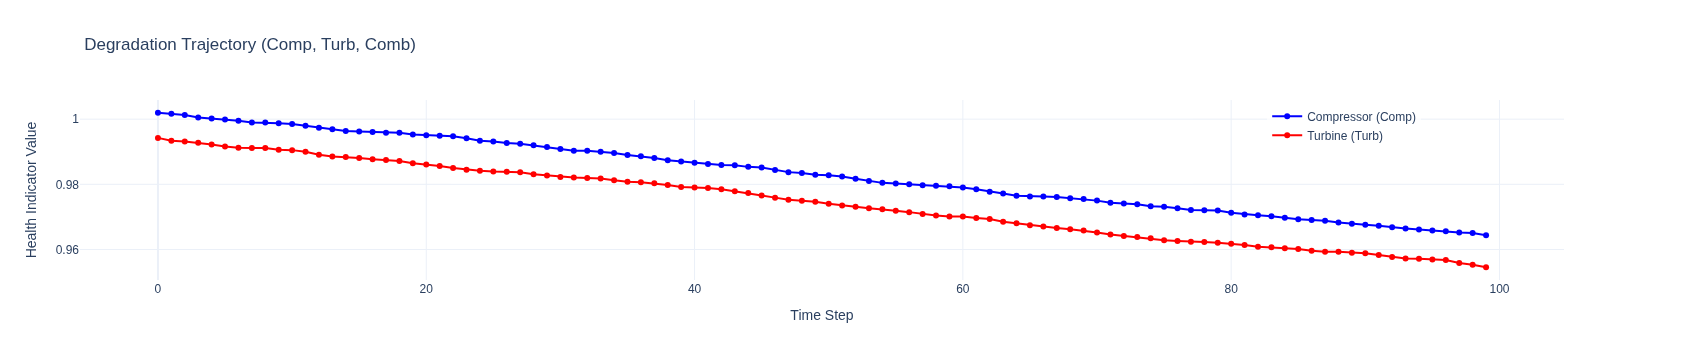

In [42]:
plot_trajectory(traj_arr[:,:2])
plot_trajectory(traj_waterwash_arr[:,:2])
plot_trajectory(traj_fast_arr[:,:2])

 Plot with 3 components

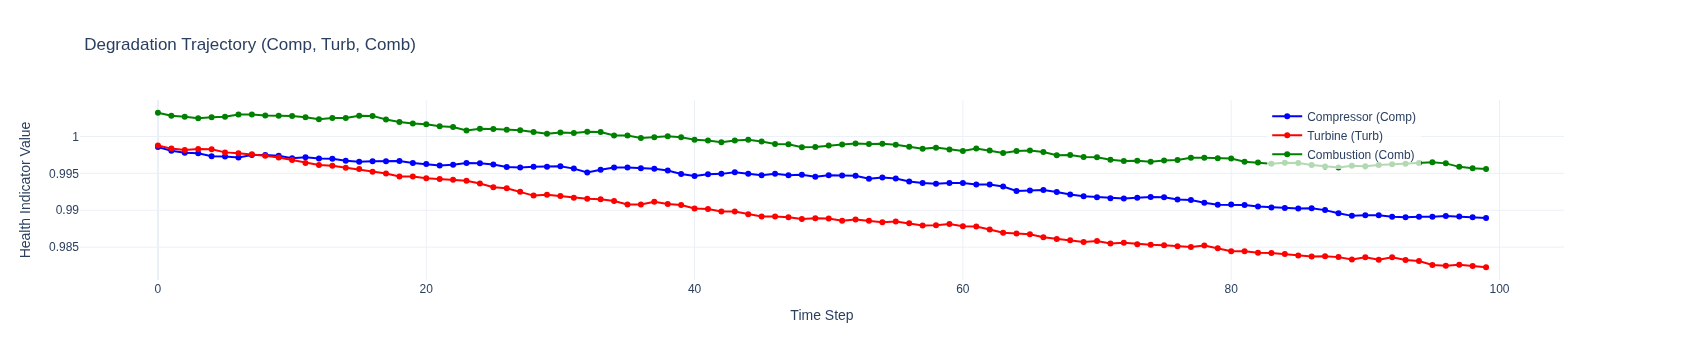

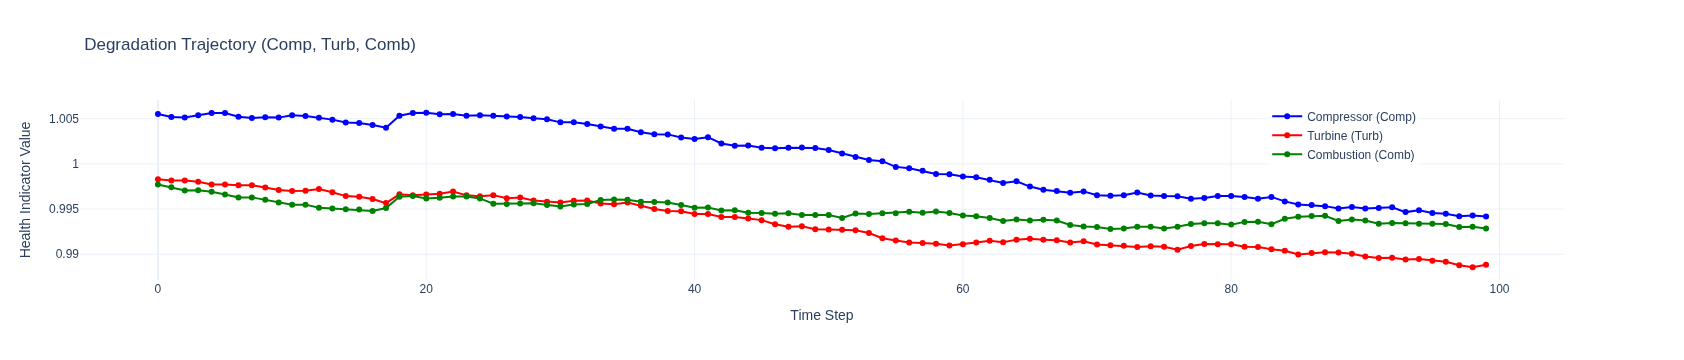

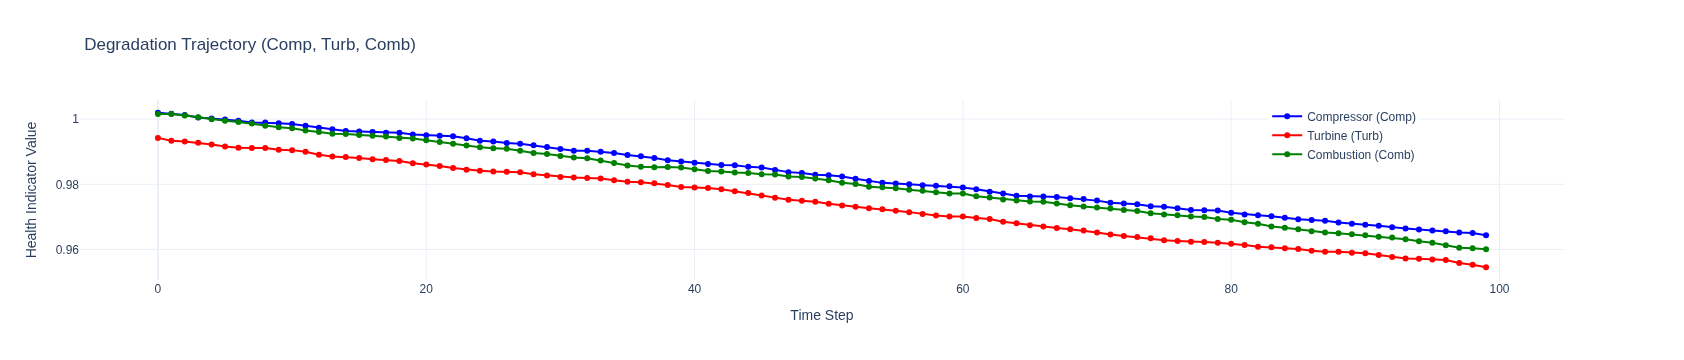

In [43]:
plot_trajectory(traj)
plot_trajectory(traj_waterwash)
plot_trajectory(traj_fast)

In [5]:
S =  ['P3', 'P4', 'P5', 'T3', 'T4', 'T5', 'W2R', 'W5', 'W8R', 'Wf', 'F']
# Note that in this simulator there is no noise added, in the challenge noise should be added
test_measurements = h_SCSF(traj, S=S, as_dict=True)

In [6]:
data_measurements = pd.DataFrame(list(test_measurements))

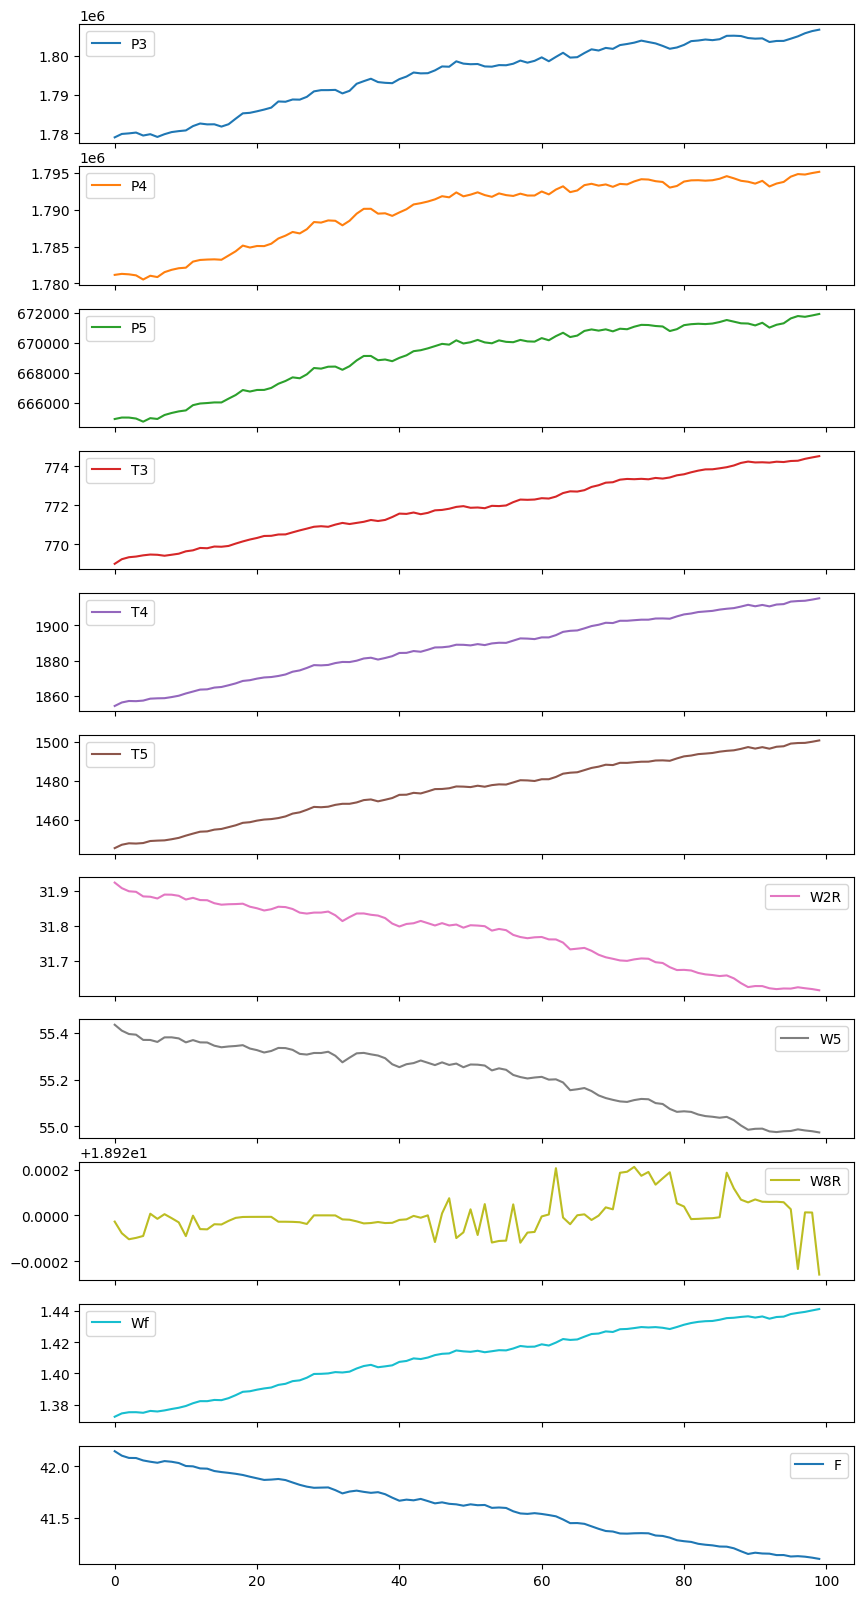

In [7]:
data_measurements.plot(subplots=True, figsize=(10, 20));

To create multiple trajetories in order to create a dataset for a challenge we implemented a simple version of a multiple trajectory generation function. This function can be found in src/scenarios.py and can be modified in order to create more adequate trajectories if needed.
By default it creates 100 trajectories.

In [8]:
multiple_traj = generate_multiple_trajectories(n_trajectories=100)

In [9]:
#multiple_traj


In [10]:
# multiple_traj is a list of dictionary
print(multiple_traj[0].keys())

dict_keys(['speed', 'waterwash', 'size', 'trajectory'])


## Solver Construction

The challenge aims to estimate at each point of the trajectory the health indicators from the measurements. One can imagine many ways to do this task. We implement in this notebook a simple NLGPA (Non Linear Gas Path Analysis) with direct optimisation (least square) for demonstration purposes. The model that aims to estimate can be a trainable model or any other methods that comes to mind. If one want to use a trainable model, then a train set have to be generated in a previous step thanks to the simulator.

---
The maxiter parameter can be increase or decrease if needed.

**Note** : 
- If too small, you may end up with a poor simulator
- If too large the execution time increase 

**Simulate with the first 2 components : comp, turb**

In [16]:

def inverse_nlgpa(y_measured, func_simu, x0=[1.0, 1.0], **kwargs):
    """
    y_measured: mesures (liste ou array)
    func_simu: simulateur f(x)
    x0: point initial pour l’optimisation
    kwargs: paramètres à passer à func_simu (ex: S=..., autre_param=...)
    """
    def loss_fn(x):
        y_pred = func_simu([x], S=S, **kwargs)
        return np.sum((np.array(y_pred) - np.array(y_measured))**2)

    result = minimize(loss_fn, x0, bounds=[(0.95, 1.02), (0.95, 1.02)], method="L-BFGS-B", options={"maxiter":10 , "disp": False})
    return result.x

def estimate_traj(measured_series, **kwargs):
    x0 = [1, 1]
    estimated_traj = []

    for i in range(len(measured_series)):
        estimated_traj_temp = inverse_nlgpa(measured_series[i], h_SCSF, x0=x0, **kwargs)
        x0 = estimated_traj_temp
        estimated_traj.append(estimated_traj_temp)

    return estimated_traj



## Tests and Results

In this chapter we test our method on a random trajectory computed thanks to the simulate_degradation_trajectory function. Since our method takes some time to compute estimation, we restrain ourself to a trajectory of size 10.

Then we compare our estimation with the true trajectory. We also compare observed measurements with the measurements we would obtain from the simulator with estimated performance indicators as inputs.

In [171]:
S =  ['P3', 'P4', 'P5', 'T3', 'T4', 'T5', 'W2R', 'W5', 'W8R', 'Wf', 'F']

In [172]:
# Generate a test trajectory
traj_test = simulate_degradation_trajectory(speed='normal', waterwash='rare', size=10, seed=0)

# If you want to try with the 3 components just use traj_test 
# Simulated measurements
measured_series_test = list(h_SCSF(np.asarray(traj_test , dtype=float) [:,:2], S=S))

In [173]:
# This step might take some times because it is not optimized, so don't hesitate to change "max iter" option in inverse_nlgpa to run the code
# just to run it for debug
estimated_traj_test = estimate_traj(measured_series_test)


/tmp/ipykernel_297377/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1193378266.py:12: DeprecationWarning:

scipy.optimize

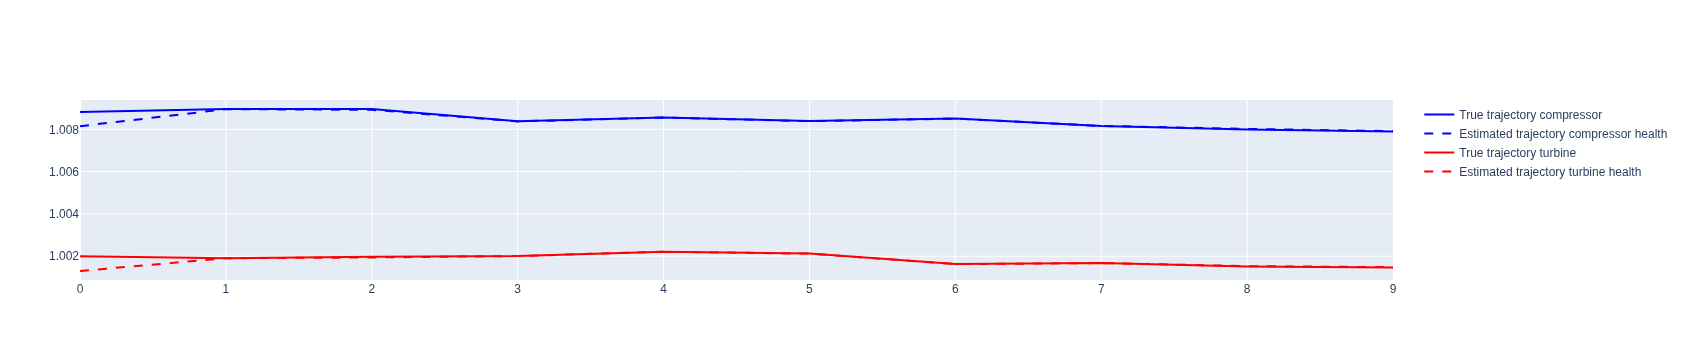

In [175]:

# Plots
true_traj = np.array(traj_test)
est_traj = np.array(estimated_traj_test)

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_traj[:, 0], mode="lines", line=dict(color="blue"), name="True trajectory compressor"))
fig.add_trace(go.Scatter(y=est_traj[:, 0], mode="lines", line=dict(color="blue", dash="dash"), name="Estimated trajectory compressor health"))

fig.add_trace(go.Scatter(y=true_traj[:, 1], mode="lines", line=dict(color="red"), name="True trajectory turbine"))
fig.add_trace(go.Scatter(y=est_traj[:, 1], mode="lines", line=dict(color="red", dash="dash"), name="Estimated trajectory turbine health"))
fig.show()





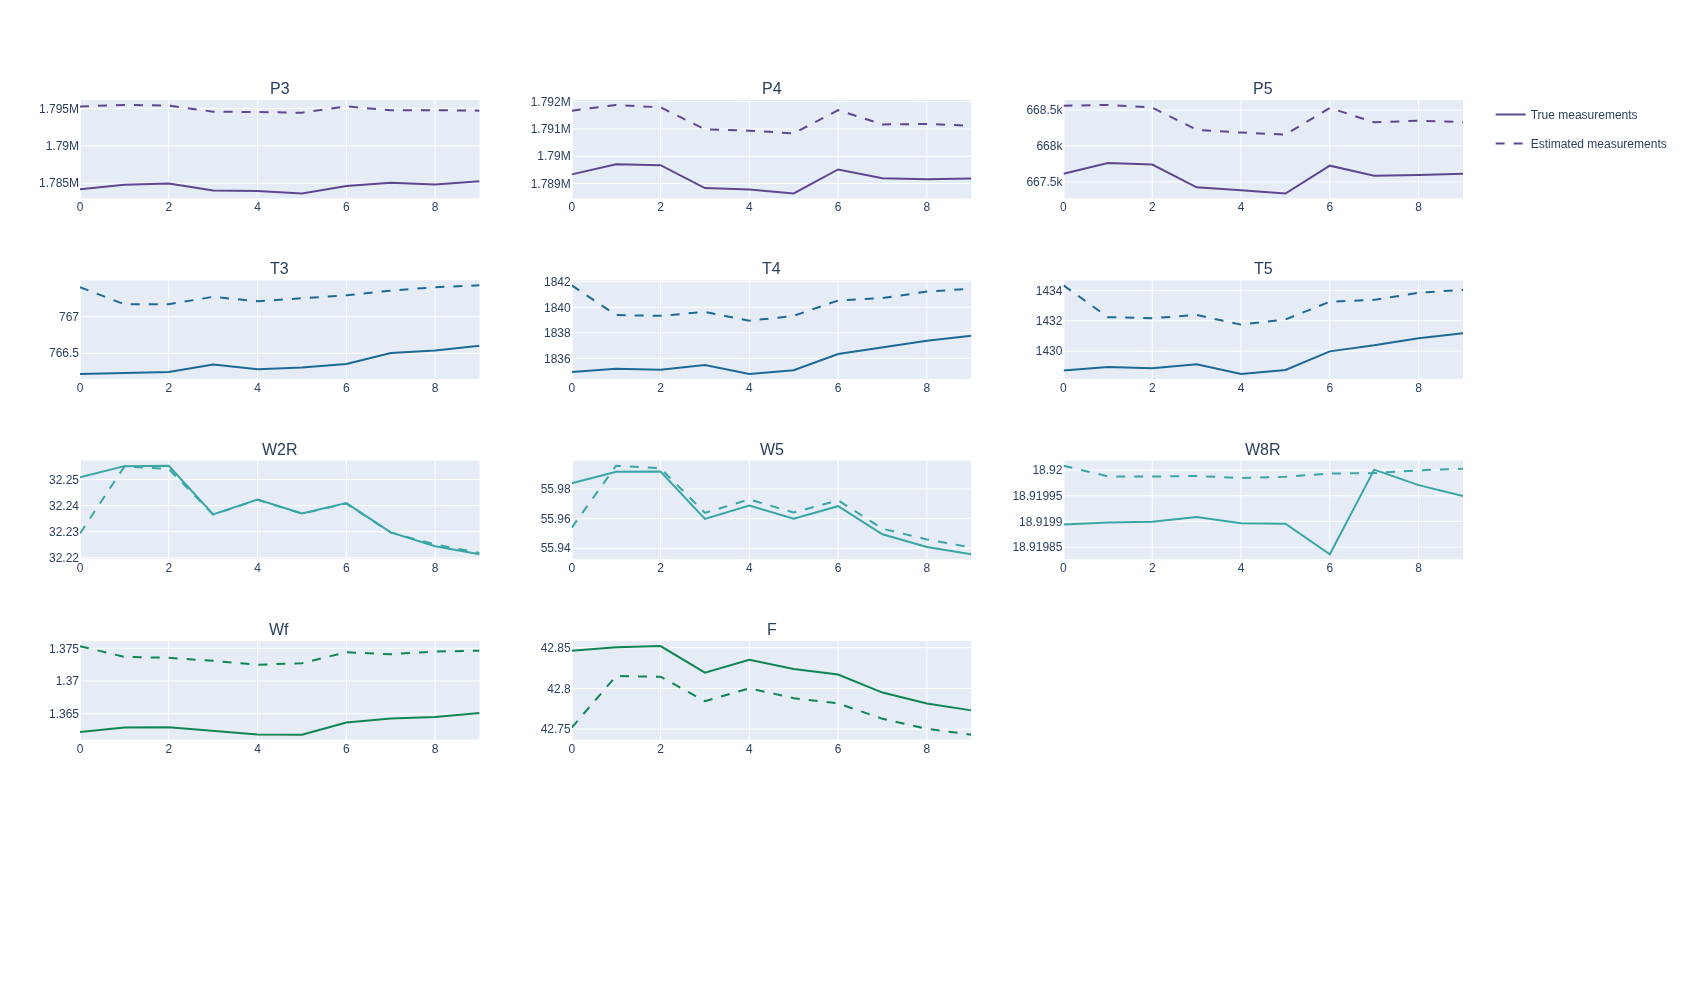

In [176]:
measured_series = pd.DataFrame(list(h_SCSF(traj_test, S=S, as_dict=True)))
measure_pred_series = pd.DataFrame(list(h_SCSF(estimated_traj_test, S=S, as_dict=True)))

palette = px.colors.qualitative.Prism
palette = palette + px.colors.qualitative.Prism

fig = make_subplots(rows=5, cols=3, subplot_titles=measured_series.columns)

i=0
j=0

show_legend=True
for col_ in measured_series.columns:

    fig.add_trace(go.Scatter(y=measured_series[col_], mode="lines", line=dict(color=palette[i]), name="True measurements", legendgroup="True measurements", showlegend=show_legend), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(y=measure_pred_series[col_], mode="lines", line=dict(color=palette[i], dash="dash"), name="Estimated measurements", legendgroup="Estimated measurements", showlegend=show_legend), row=i+1, col=j+1)

    j+=1
    if j > 2:
        j=0
        i+=1

    if show_legend:
        show_legend = False


fig.update_layout(height=200*5)
fig.show()


Next we also compute numerical score of our methodology. We use two different scoring :
1) RMSE error along the trajectory for each indicator
2) Slope error for each indicator

In [177]:
def trajectory_error(traj, est):

    traj = np.array(traj)
    est = np.array(est)
    out_0 = np.sqrt(np.sum((traj[:,0] - est[:,0])**2))
    out_1 = np.sqrt(np.sum((traj[:,1] - est[:,1])**2))

    out = [out_0, out_1]

    return out

def slope_error(traj, est): # We should certainly add a window size, because slope for 1 step time is not ok
    traj = np.array(traj)
    est = np.array(est)

    def total_slope(coord):
        return coord[-1] - coord[0]

    # Pente totale sur X
    slope_x_real = total_slope(traj[:, 0])
    slope_x_est = total_slope(est[:, 0])
    error_slope_x = slope_x_est - slope_x_real

    # Pente totale sur Y
    slope_y_real = total_slope(traj[:, 1])
    slope_y_est = total_slope(est[:, 1])
    error_slope_y = slope_y_est - slope_y_real

    return [error_slope_x, error_slope_y]


In [178]:
true_traj

array([[1.00882026, 1.00200079, 1.00489369],
       [1.0089551 , 1.00190787, 1.0047535 ],
       [1.00896017, 1.0019746 , 1.0046388 ],
       [1.00837778, 1.00201158, 1.00469461],
       [1.00855548, 1.00221193, 1.00470884],
       [1.00838889, 1.00212544, 1.00481528],
       [1.00851208, 1.00163108, 1.00474947],
       [1.00816089, 1.00167639, 1.00431793],
       [1.00799516, 1.00150931, 1.00442635],
       [1.00789931, 1.00146924, 1.00420806]])

In [179]:
traj_error = trajectory_error(true_traj, est_traj)
slope_error = slope_error(true_traj, est_traj)
print(traj_error, slope_error)

[np.float64(0.0006746192039283668), np.float64(0.0007021552787090949)] [np.float64(0.0006887783150406612), np.float64(0.0007136192686230114)]


In [180]:
len(traj_error)

2

In [181]:
current_val1 = np.random.normal(1.0, 0.005)
current_val1

0.9981862941700643

In [182]:
np.random.normal(1.0, 0.005)

0.9982318607175956

## **Try with 3 components : comp, Turb, Comb**

In [9]:
# Update the simulator for 3 components

def inverse_nlgpa(y_measured, func_simu, x0=[1.0, 1.0, 1.0], **kwargs):
    """
    y_measured: mesures (liste ou array)
    func_simu: simulateur f(x)
    x0: point initial pour l’optimisation
    kwargs: paramètres à passer à func_simu (ex: S=..., autre_param=...)
    """
    def loss_fn(x):
        y_pred = func_simu([x], S=S, **kwargs)
        return np.sum((np.array(y_pred) - np.array(y_measured))**2)

    result = minimize(loss_fn, x0, bounds=[(0.95, 1.02), (0.95, 1.02), (0.95, 1.02)], method="L-BFGS-B", options={"maxiter":10 , "disp": False})
    return result.x

def estimate_traj(measured_series, **kwargs):
    x0 = [1, 1, 1]
    estimated_traj = []

    for i in range(len(measured_series)):
        estimated_traj_temp = inverse_nlgpa(measured_series[i], h_SCSF, x0=x0, **kwargs)
        x0 = estimated_traj_temp
        estimated_traj.append(estimated_traj_temp)

    return estimated_traj



In [183]:

#------------------------------------------------------    
S =  ['P3', 'P4', 'P5', 'T3', 'T4', 'T5', 'W2R', 'W5', 'W8R', 'Wf', 'F']
# Generate a test trajectory
traj_test = simulate_degradation_trajectory(speed='normal', waterwash='rare', size=10, seed=0)

# If you want to try with the 3 components just use traj_test 
# Simulated measurements
measured_series_test = list(h_SCSF(np.asarray(traj_test , dtype=float), S=S))



#-----------------------------------------------------------------------------------------------------------------------------------------------
# This step might take some times because it is not optimized, so don't hesitate to change "max iter" option in inverse_nlgpa to run the code
# just to run it for debug
estimated_traj_test = estimate_traj(measured_series_test)

#-----------------------------------------------------------------------------------------------------------------------------------------------




/tmp/ipykernel_297377/1481125563.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1481125563.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1481125563.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1481125563.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1481125563.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_297377/1481125563.py:12: DeprecationWarning:

scipy.optimize

In [184]:


# Plots trajectories 
true_traj = np.array(traj_test)

est_traj = np.array(estimated_traj_test)

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_traj[:, 0], mode="lines", line=dict(color="blue"), name="True trajectory compressor"))
fig.add_trace(go.Scatter(y=est_traj[:, 0], mode="lines", line=dict(color="blue", dash="dash"), name="Estimated trajectory compressor health"))

fig.add_trace(go.Scatter(y=true_traj[:, 1], mode="lines", line=dict(color="red"), name="True trajectory turbine"))
fig.add_trace(go.Scatter(y=est_traj[:, 1], mode="lines", line=dict(color="red", dash="dash"), name="Estimated trajectory turbine health"))


fig.add_trace(go.Scatter(y=true_traj[:, 2], mode="lines", line=dict(color="green"), name="True trajectory Combustor"))
fig.add_trace(go.Scatter(y=est_traj[:, 2], mode="lines", line=dict(color="green", dash="dash"), name="Estimated trajectory combustor health"))
fig.show()



#-----------------------------------------------------------------------------------------------------------------------------------------------


# Plots measurements  
measured_series = pd.DataFrame(list(h_SCSF(traj_test, S=S, as_dict=True)))
measure_pred_series = pd.DataFrame(list(h_SCSF(estimated_traj_test, S=S, as_dict=True)))

palette = px.colors.qualitative.Prism
palette = palette + px.colors.qualitative.Prism

fig = make_subplots(rows=5, cols=3, subplot_titles=measured_series.columns)

i=0
j=0

show_legend=True
for col_ in measured_series.columns:

    fig.add_trace(go.Scatter(y=measured_series[col_], mode="lines", line=dict(color=palette[i]), name="True measurements", legendgroup="True measurements", showlegend=show_legend), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(y=measure_pred_series[col_], mode="lines", line=dict(color=palette[i], dash="dash"), name="Estimated measurements", legendgroup="Estimated measurements", showlegend=show_legend), row=i+1, col=j+1)

    j+=1
    if j > 2:
        j=0
        i+=1

    if show_legend:
        show_legend = False


fig.update_layout(height=200*5)
fig.show()


# Try the simualation using only T5 and P3

- Tried with 2 components

In [17]:
# create measurements
# traj_fast = simulate_degradation_trajectory(speed="fast") # Takes a lot of time
traj_fast = simulate_degradation_trajectory(speed='fast', waterwash='rare', size=10, seed=0)
# Selected sensors
S = ['P3', 'T5']

measured_series_fast = list(h_SCSF( np.asarray(traj_fast, dtype=float)[:,:2]  , S=S))
# traj_test , dtype=float) [:,:2]
#
estimated_traj_test = estimate_traj(measured_series_fast)


/tmp/ipykernel_305802/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_305802/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_305802/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_305802/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_305802/1193378266.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipykernel_305802/1193378266.py:12: DeprecationWarning:

scipy.optimize

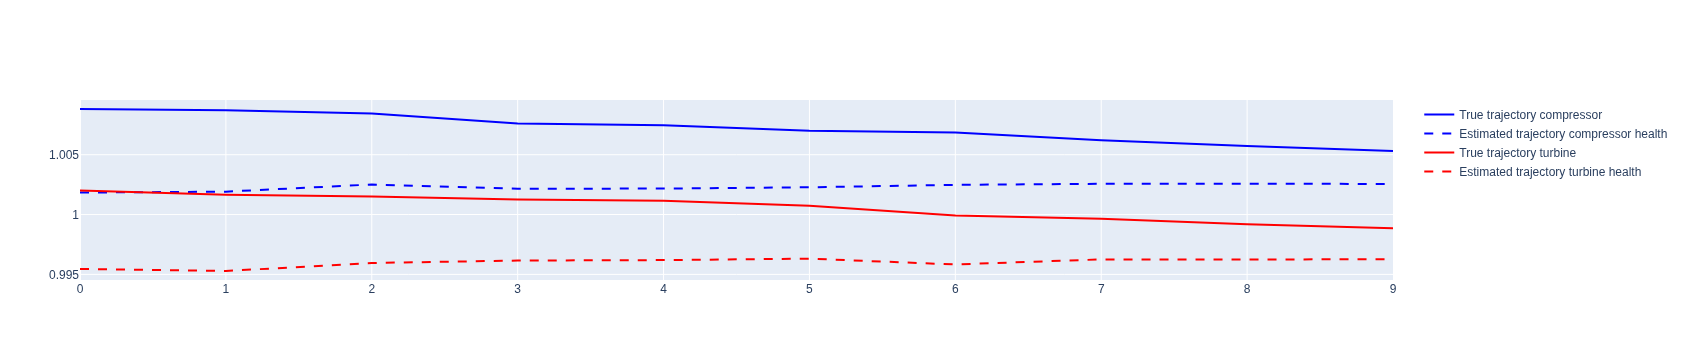

In [18]:
# Visualising
true_traj = np.array(traj_fast)
est_traj = np.array(estimated_traj_test)

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_traj[:, 0], mode="lines", line=dict(color="blue"), name="True trajectory compressor"))
fig.add_trace(go.Scatter(y=est_traj[:, 0], mode="lines", line=dict(color="blue", dash="dash"), name="Estimated trajectory compressor health"))

fig.add_trace(go.Scatter(y=true_traj[:, 1], mode="lines", line=dict(color="red"), name="True trajectory turbine"))
fig.add_trace(go.Scatter(y=est_traj[:, 1], mode="lines", line=dict(color="red", dash="dash"), name="Estimated trajectory turbine health"))


fig.show()

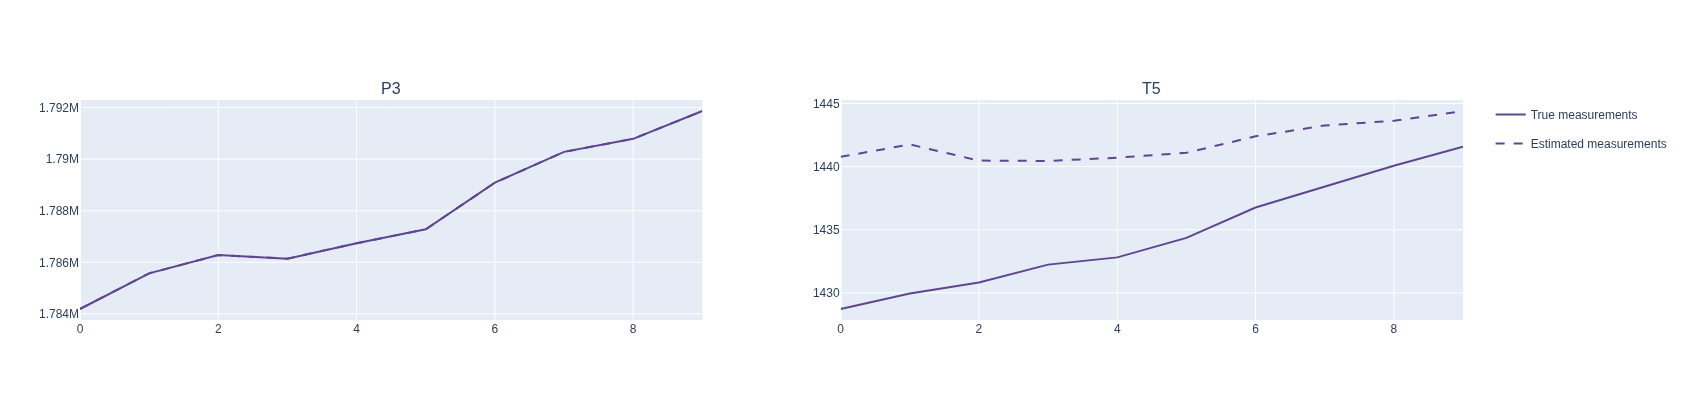

In [13]:
# Plot measurement estimated vs true ones

measured_series = pd.DataFrame(list(h_SCSF( traj_fast, S=S, as_dict=True)))
measure_pred_series = pd.DataFrame(list(h_SCSF(estimated_traj_test, S=S, as_dict=True)))

palette = px.colors.qualitative.Prism
palette = palette + px.colors.qualitative.Prism

fig = make_subplots(rows=1, cols=2, subplot_titles=measured_series.columns)

i=0
j=0

show_legend=True
for col_ in measured_series.columns:

    fig.add_trace(go.Scatter(y=measured_series[col_], mode="lines", line=dict(color=palette[i]), name="True measurements", legendgroup="True measurements", showlegend=show_legend), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(y=measure_pred_series[col_], mode="lines", line=dict(color=palette[i], dash="dash"), name="Estimated measurements", legendgroup="Estimated measurements", showlegend=show_legend), row=i+1, col=j+1)

    j+=1
    if j > 2:
        j=0
        i+=1

    if show_legend:
        show_legend = False



fig.update_layout(height=200*2)
fig.show()



## Try with 3 components

In [10]:
# create measurements
# traj_fast = simulate_degradation_trajectory(speed="fast") # Takes a lot of time
traj_fast = simulate_degradation_trajectory(speed='fast', waterwash='rare', size=10, seed=0)
# Selected sensors
S = ['P3', 'T5']

measured_series_fast = list(h_SCSF( traj_fast  , S=S))
# traj_test , dtype=float) [:,:2]

# Function 
estimated_traj_test = estimate_traj(measured_series_fast)


/tmp/ipykernel_305802/1301257407.py:14: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(loss_fn, x0, bounds=[(0.95, 1.02), (0.95, 1.02), (0.95, 1.02)], method="L-BFGS-B", options={"maxiter":10 , "disp": False})
/tmp/ipykernel_305802/1301257407.py:14: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(loss_fn, x0, bounds=[(0.95, 1.02), (0.95, 1.02), (0.95, 1.02)], method="L-BFGS-B", options={"maxiter":10 , "disp": False})
/tmp/ipykernel_305802/1301257407.py:14: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(loss_fn, x0, bounds=[(0.95, 1.02), (0.95, 1.02), (0.95, 1.02)], method="L-BFGS-B", options={"maxiter":10 , "disp": False})
/tmp/ipykernel_305802/

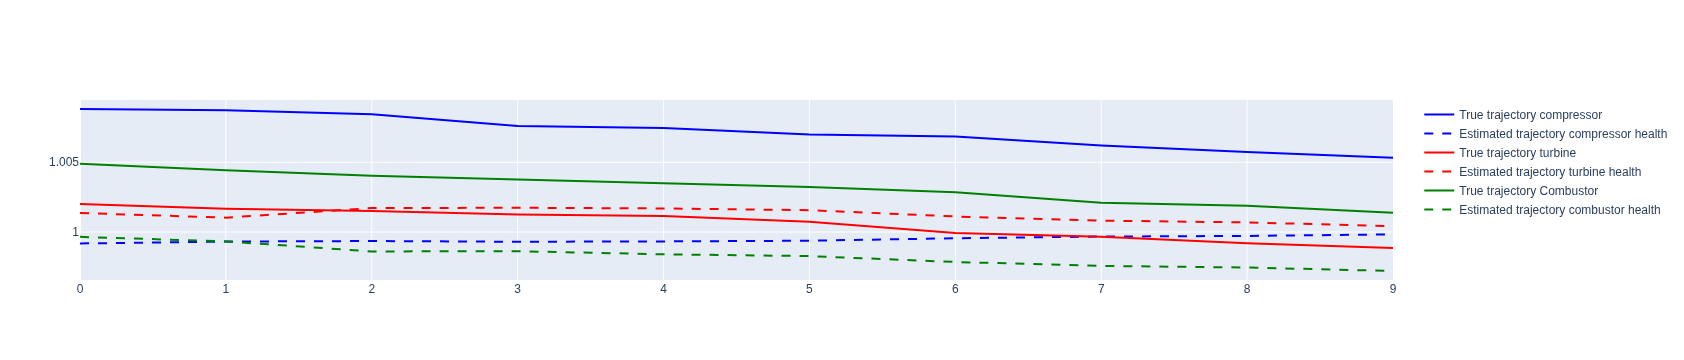

In [15]:
# Visualising
true_traj = np.array(traj_fast)
est_traj = np.array(estimated_traj_test)

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_traj[:, 0], mode="lines", line=dict(color="blue"), name="True trajectory compressor"))
fig.add_trace(go.Scatter(y=est_traj[:, 0], mode="lines", line=dict(color="blue", dash="dash"), name="Estimated trajectory compressor health"))

fig.add_trace(go.Scatter(y=true_traj[:, 1], mode="lines", line=dict(color="red"), name="True trajectory turbine"))
fig.add_trace(go.Scatter(y=est_traj[:, 1], mode="lines", line=dict(color="red", dash="dash"), name="Estimated trajectory turbine health"))

fig.add_trace(go.Scatter(y=true_traj[:, 2], mode="lines", line=dict(color="green"), name="True trajectory Combustor"))
fig.add_trace(go.Scatter(y=est_traj[:, 2], mode="lines", line=dict(color="green", dash="dash"), name="Estimated trajectory combustor health"))


fig.show()

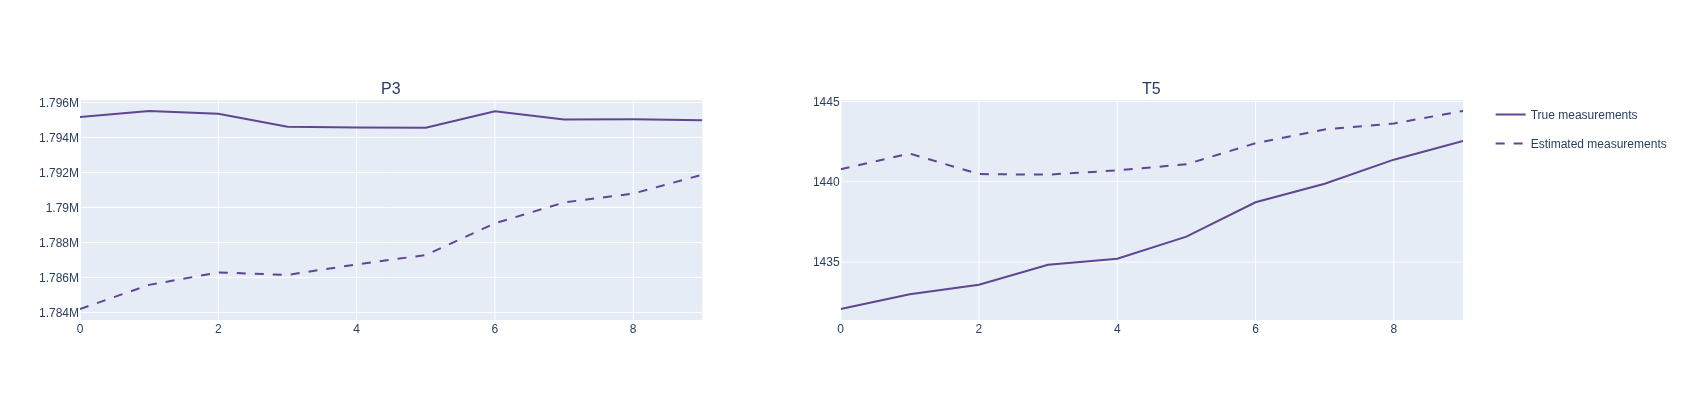

In [14]:
# Plot measurement estimated vs true ones

measured_series = pd.DataFrame(list(h_SCSF( np.asarray(traj_fast, dtype=float)[:,:2], S=S, as_dict=True)))
measure_pred_series = pd.DataFrame(list(h_SCSF(estimated_traj_test, S=S, as_dict=True)))

palette = px.colors.qualitative.Prism
palette = palette + px.colors.qualitative.Prism

fig = make_subplots(rows=1, cols=2, subplot_titles=measured_series.columns)

i=0
j=0

show_legend=True
for col_ in measured_series.columns:

    fig.add_trace(go.Scatter(y=measured_series[col_], mode="lines", line=dict(color=palette[i]), name="True measurements", legendgroup="True measurements", showlegend=show_legend), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(y=measure_pred_series[col_], mode="lines", line=dict(color=palette[i], dash="dash"), name="Estimated measurements", legendgroup="Estimated measurements", showlegend=show_legend), row=i+1, col=j+1)

    j+=1
    if j > 2:
        j=0
        i+=1

    if show_legend:
        show_legend = False



fig.update_layout(height=200*2)
fig.show()

